In [1]:
from abc import ABC, abstractmethod
from typing import Tuple, Dict, List, Union

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Polluter(ABC):
    """
    This class defines an abstract base class of a polluter.
    """

    def __init__(self, random_seed: int) -> None:
        """
        This method initializes the random seed and random generator.
        :param random_seed: the random seed
        """

        self.random_seed = random_seed
        self.random_generator = np.random.default_rng(random_seed)

    @staticmethod
    @abstractmethod
    def get_static_params(metadata: dict, dataset: pd.DataFrame, ds_name: str) -> dict:
        """
        Generates a dictionary of static parameters to initialize the own specialized polluter instances from.
        This is done by reading the appropriate fields in the metadata dictionary section corresponding to the given
        dataset name and/or analyzing the given dataset.

        :param metadata: dataset metadata dictionary read from the metadata.json file
        :type metadata: dict
        :param dataset: raw dataset as read from disk
        :type dataset: pd.DataFrame
        :param ds_name: name of the dataset file - same as the key in the metadata dictionary
        :type ds_name: str
        :returns: parameter dictionary to use in polluter instance initialization
        :rtype: dict
        """
        raise NotImplementedError('Please implement the get_static_params function in each specialized polluter!')

    @classmethod
    @abstractmethod
    def configure(cls, metadata: dict, dataset: pd.DataFrame, ds_name: str) -> List['Polluter']:
        """
        Configures the special polluter, setting its parameters based on the metadata, dataset, dataset name
        and random seed provided.
        In addition to fixed per-dataset parameters, each polluter may specify, in this class, ranges from which to
        pull flexible parameters (e.g. percentage of samples to pollute).
        This function returns a list of configured polluter instances.

        :param metadata: dataset metadata dictionary read from the metadata.json file
        :type metadata: dict
        :param dataset: raw dataset as read from disk
        :type dataset: pd.DataFrame
        :param ds_name: name of the dataset file - same as the key in the metadata dictionary
        :type ds_name: str
        :returns: list of configured polluter instances
        :rtype: list
        """

        # Hint: Implement and use the get_static_params function for cleaner code!
        # Basic structure example:
        #
        # configured_polluters = list()
        # static_params = cls.get_static_params(metadata, dataset, ds_name)
        # for rand_seed in metadata['random_seeds']:
        #     for pol_level in [i / 20 for i in range(21)]:
        #         configured_polluters.append(cls(pol_level=pol_level, random_seed=rand_seed, **static_params))
        # return configured_polluters
        raise NotImplementedError('Please implement the configure function in each specialized polluter!')

    @abstractmethod
    def pollute(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        The pollute method takes care of polluting the received dataframe.

        :param df: the dataframe that is to be polluted
        :return: the polluted dataframe
        """
        pass

    @abstractmethod
    def compute_quality_measure(self, df_polluted: pd.DataFrame, df_clean: pd.DataFrame=None) \
            -> Union[float, Tuple[float, float]]:
        """
        This method calculates the quality measure of the polluted dataframe.

        :param df_polluted: the polluted dataframe (required)
        :param df_clean: the original dataframe (optional)
        :return: the quality measure/s of the polluted dataframe
        """
        pass

    def __call__(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Union[float, Tuple[float, float]]]:
        """
        The __call__ method allows the instantiated objects of the Polluter class to be called like functions. This
        will return both the polluted dataset and the quality measure calculated for it.

        :param df: the dataframe that is to be polluted
        :return: the polluted dataframe and its quality measure/s
        """

        df_polluted = self.pollute(df)
        return df_polluted, self.compute_quality_measure(df_polluted, df)

    def poll_params(self) -> str:
        """
        Returns the string representation of the dictionary of all member variables, excluding the random generator.
        This is hashed and used for file naming purposes later on, which is why the object location reference for the
        random generator needs to be excluded (it is not always at the same location in memory).

        :returns: string representation of the member variable dictionary, excluding random generator field
        :rtype: str
        """
        return str({k: str(v) for k, v in vars(self).items() if k != 'random_generator'})

In [3]:
import logging
import numpy as np
import pandas as pd

from math import ceil, floor
from typing import List


def _calc_per_class_samples(inter_class_distance, class_order, balanced_per_class_samples):
    """
    Calculates how many samples each class should have in the polluted dataset and returns a list of class_id,
    sample_count tuples.

    :param inter_class_distance: distance (difference of sample counts) for two adjacent classes
    :param class_order: list of class_id, available_sample_count sorted (ASC) by sample count, then class id
    :param balanced_per_class_samples: samples per class in the (hypothetical) balanced baseline dataset
    :return: list of calculated sample counts to return with the polluted dataset per class
    :rtype: list([class_id, int])
    """
    per_class_samples = list()
    m = len(class_order)    # number of classes in target
    # calculate the number of samples to return for the smallest class
    if m % 2 == 1:
        # for m odd: balanced_samples - (floor(m / 2) * distance)
        per_class_samples.append([
            class_order[0],
            int(balanced_per_class_samples - (floor(m / 2) * inter_class_distance))
        ])
    else:
        # for m even: balanced_samples - (((m / 2) - 0.5) * distance)
        per_class_samples.append([
            class_order[0],
            int(balanced_per_class_samples - (((m / 2) - 0.5) * inter_class_distance))
        ])

    for i in range(1, len(class_order)):
        per_class_samples.append([class_order[i], per_class_samples[i-1][1] + inter_class_distance])
    return per_class_samples


def _sum_absolute_per_class_distances(m, per_class_distance):
    """
    Calculates and returns the sum of absolute per-class sample count distances (differences).
    This is based on the number of classes and the defined distance between per-class sample counts.
    The calculation already eliminates duplicate edges (e.g. A -> C is considered, so C -> A is not).

    :param m: number of classes in the dataset
    :param per_class_distance: difference in per-class sample count
    :return: sum of absolute per-class sample count differences
    :rtype: int
    """
    return per_class_distance * sum([(m - pcd_mult) * pcd_mult for pcd_mult in range(m)])


def _calc_sample_counts(percentages, highest_possible):
    """
    Calculates, for the given list of percentages and a maximum number the absolute values corresponding
    to these percentages in reference to the given maximum.

    :param percentages: list of floats in [0.0, 1.0]
    :param highest_possible: integer denoting the reference to apply the percentages to (i.e. the 100% value)
    :return: sorted (asc) list of integers similar to to round(percentages * highest_possible)
             the difference between two adjacent values is always the same
    """
    percentages = sorted(percentages)
    potential_counts = [round(sam_pct * highest_possible) for sam_pct in percentages]
    # ensure that the differences are REALLY always the same, just to be sure!
    diffs = [potential_counts[i+1] - potential_counts[i] for i in range(len(potential_counts) - 1)]
    equalized_diff = floor(sum(diffs) / len(diffs))
    counts = [potential_counts[0] + i * equalized_diff for i in range(len(potential_counts))]
    return counts


def _max_lvl_percentages(m):
    """
    For maximum imbalance, we fix that largest class is at 100% of samples allowed and smallest class is at
    1% of samples allowed. All other classes in between are equally spaced in terms of percentage.

    Therefore, we calculate the spacing between percentages as 0.99 (remaining percentage from 0.01 to 1.0) / m-1
    (number of spaces).

    :param m: number of classes in target
    :returns: percentage of samples allowed for each class, assuming classes sorted by sample count in original data
    :rtype: list
    """
    spacing = 0.99 / (m - 1)
    return [0.01] + [0.01 + (i * spacing) for i in range(1, m - 1)] + [1.0]


def _calc_imbalance_level(m, n, per_class_distance):
    """
    Calculates the imbalance level based on dataset metrics and absolute per-class sample count distance
    (difference).

    :param m: number of classes in the dataset
    :param n: total number of samples the polluter will return
    :param per_class_distance: difference in sample count for two adjacent classes in the polluted dataset
    :return: imbalance level
    :rtype: float
    """
    return _sum_absolute_per_class_distances(m, per_class_distance) / (((m + 1) / 3) * n)


def _calc_max_lvl_sample_counts(per_class_samples, n_samples_to_return=None):
    """
    Calculates the number of samples to return per class when assuming maximum imbalance. Ensures that this is
    possible by setting the number of samples for the largest class accordingly.

    :param per_class_samples: number of samples available in the original data per class
    :type per_class_samples: list
    :param n_samples_to_return: number of samples to return with the polluted dataset, optional
    :type n_samples_to_return: int
    :returns: sample count per class, assuming classes sorted by sample count in original data
    :rtype: list
    """
    # sorts per-class sample counts ascending
    sorted_pcs = sorted(per_class_samples)
    # gets number of distinct classes in target
    m = len(sorted_pcs)
    # returns maximum pollution percentages for per class samples in reference to largest class sample count
    percentages = _max_lvl_percentages(m)

    # can't get more samples than the most-represented class has
    highest_possible = sorted_pcs[-1]
    # iterate through smaller classes, reduce the highest possible sample count to return as needed
    for i in range(m - 1):
        highest_possible = min(highest_possible, floor(sorted_pcs[i] / percentages[i]))

    # ensure that the final per-class sample counts are created in a way that a balanced dataset can be created
    # 1. Sum of maximum imbalance per-class sample counts needs to be dividable by the number of classes
    # 2. Sum of maximum imbalance per-class sample counts divided by number of classes can't be larger than smallest class sample count
    # 3. Sum of maximum imbalance per-class sample counts can't be larger than number of samples to return (if given)
    while sum(_calc_sample_counts(percentages, highest_possible)) % m != 0 or \
            sum(_calc_sample_counts(percentages, highest_possible)) // m > sorted_pcs[0] or \
            (n_samples_to_return is not None and sum(_calc_sample_counts(percentages, highest_possible)) > n_samples_to_return):
        highest_possible -= 1

    return _calc_sample_counts(percentages, highest_possible)


def _calc_max_samples(per_class_samples):
    """
    Calculates and returns the maximum possible total sample count to return for a given list of per-class sample
    counts.

    :param per_class_samples: list of integers, sample counts for each class
    :return: maximum possible total number of samples for balancing/imbalancing
    :rtype: int
    """
    return sum(_calc_max_lvl_sample_counts(per_class_samples))


class ClassBalancePolluter(Polluter):
    """
    This class implements a class balance polluter, which changes the balance of per-class sample counts in a given
    dataset. This imbalance is created on a balanced baseline by adding / removing an equal amount of samples
    per class with more samples being removed for classes further away from the middle of a list sorted ascending
    by sample count and then class name in the original dataset. I.e. the sample counts of the resulting dataset will
    always approximate a straight line if sorted.
    """

    @staticmethod
    def get_static_params(metadata: dict, dataset: pd.DataFrame, ds_name: str) -> dict:
        """ Generates a dictionary of static parameters to initialize the own specialized polluter instances from.
        This is done by reading the appropriate fields in the metadata dictionary section corresponding to the given
        dataset name and/or analyzing the given dataset.

        :param metadata: dataset metadata dictionary read from the metadata.json file
        :type metadata: dict
        :param dataset: raw dataset as read from disk
        :type dataset: pd.DataFrame
        :param ds_name: name of the dataset file - same as the key in the metadata dictionary
        :type ds_name: str
        :returns: parameter dictionary to use in polluter instance initialization
        :rtype: dict
        """
        spec_meta = metadata[ds_name]
        return {
            'target_column': spec_meta['target'],
            'n_samples': len(dataset) if spec_meta.get('n_samples') is None else spec_meta.get('n_samples')
        }

    @classmethod
    def configure(cls, metadata: dict, dataset: pd.DataFrame, ds_name: str) -> List['Polluter']:
        """ Configures the special polluter, setting its parameters based on the metadata, dataset, dataset name
        and random seed provided.
        In addition to fixed per-dataset parameters, each polluter may specify, in this class, ranges from which to
        pull flexible parameters (e.g. percentage of samples to pollute).
        This function returns a list of configured polluter instances.

        :param metadata: dataset metadata dictionary read from the metadata.json file
        :type metadata: dict
        :param dataset: raw dataset as read from disk
        :type dataset: pd.DataFrame
        :param ds_name: name of the dataset file - same as the key in the metadata dictionary
        :type ds_name: str
        :returns: list of configured polluter instances
        :rtype: list
        """
        configured_polluters = list()
        static_params = cls.get_static_params(metadata, dataset, ds_name)
        for rand_seed in metadata['random_seeds']:
            for imbalance_level in [i / 10 for i in range(11)]:
                configured_polluters.append(cls(imbalance_level=imbalance_level, random_seed=rand_seed, **static_params))
        return configured_polluters

    def __init__(self, imbalance_level: float, target_column: str, n_samples: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._imbalance_level = imbalance_level
        self._target_col = target_column
        self._target_n_samples = np.inf if n_samples is None else n_samples

    def compute_quality_measure(self, df_polluted: pd.DataFrame, df_clean: pd.DataFrame = None) -> float:
        """
        This method calculates the quality measure of the polluted dataframe.
        For the class balance, it is presumed to be worst (quality = 0) if the class sample
        counts alternate between the maximum sample count and no samples at all. This can never
        occur and, thus, constitutes a theoretical minimum. The maximum balance of 1 is achieved
        if all classes have the same sample count.

        From the theoretical minimum, we can determine the maximum possible sum of per-class
        sample count differences to be floor(m/2) * ceil(m/2) * max sample count.
        Calculating the actual sum of per-class sample count differences and using this theoretical
        difference, we can calculate the quotient, which is the measure of how imbalanced the dataset
        is, 1 being the most imbalanced. Calculating 1 - this measure, we get the quality measure.

        :param df_polluted: the polluted dataframe (required)
        :param df_clean: the original dataframe, unused for this quality measure
        :return: the quality measure of the polluted dataframe
        """
        # number of classes
        m = df_polluted[self._target_col].nunique()
        # per-class sample counts
        class_sample_counts = df_polluted[self._target_col].value_counts().to_dict()
        # list of (classname, sample count) sorted descending by sample count first and class name second
        class_order = sorted(class_sample_counts.items(), key=lambda el: (el[1], el[0]), reverse=True)

        # maximum distance between two individual classes (= empirical maximum possible sample count)
        max_ind_dist = class_order[0][1]
        # maximum distance in the whole class system, assuming pairwise distances to be taken only in one direction
        max_tot_dist = ceil(m/2) * floor(m/2) * max_ind_dist

        ind_distances = list()
        for i, (_, majority_count) in enumerate(class_order):
            for _, minority_count in class_order[i + 1:]:
                ind_distances.append(majority_count - minority_count)

        return 1.0 - (sum(ind_distances) / max_tot_dist)

    def pollute(self, df: pd.DataFrame) -> pd.DataFrame:
        # generate the order of classes based on their sample count first and name second
        class_sample_counts = df[self._target_col].value_counts().to_dict()
        class_order = sorted(class_sample_counts.items(), key=lambda el: (el[1], el[0]))

        # calculated how many samples would be used at maximum pollution level
        max_samp_count = _calc_max_samples([tup[1] for tup in class_order])

        # tell user if we can't return as many samples as desired
        if max_samp_count < self._target_n_samples:
            logging.warning(f'The maximum possible number of samples that can be returned ({max_samp_count}) '
                            f'is smaller than the desired number of samples to return ({self._target_n_samples}).\n'
                            f'Will return maximum possible number of samples.')
            self._target_n_samples = max_samp_count

        # ensure that, in a balanced dataset, all classes can have the same sample count (none are off by one)
        original_target_n_samples = self._target_n_samples
        while self._target_n_samples % len(class_sample_counts) != 0:
            self._target_n_samples -= 1
        if original_target_n_samples != self._target_n_samples:
            logging.warning(f'As the original target number of samples ({original_target_n_samples}) was not dividable '
                            f'by the number of classes without leaving a remainder, it was changed to '
                            f'({self._target_n_samples}).')

        # calculate, in case of maximum pollution level, how many samples per class would be returned
        max_pc_samples = _calc_max_lvl_sample_counts([tup[1] for tup in class_order], self._target_n_samples)

        # calculate, based on the imbalance level, how many samples difference there will be between
        # adjacent classes in the returned dataframe
        inter_class_dist = self._calc_absolute_per_class_distance(self._imbalance_level,
                                                                  len(class_order),        # num classes
                                                                  self._target_n_samples,  # num samples desired
                                                                  max_pc_samples[-1])      # "100%" at max poll. level

        # calculate the actual per-class sample count to extract and return
        per_class_samples = _calc_per_class_samples(inter_class_dist,
                                                    [tup[0] for tup in class_order],
                                                    self._target_n_samples / len(class_order))  # samples per class if balanced

        if sum([s_count for _, s_count in per_class_samples]) != self._target_n_samples:
            diff = self._target_n_samples - sum([s_count for _, s_count in per_class_samples])
            assert diff < len(per_class_samples), f'Something is really wrong, missed samples ({diff}) may never be ' \
                                                  f'larger than the number of classes ({len(per_class_samples)}) ' \
                                                  f'as they could\'ve been split up over the classes!'
            margin = len(per_class_samples) - diff  # how many classes to not touch on higher side of distribution
            for i in range(len(per_class_samples) - margin - diff, len(per_class_samples) - margin):
                per_class_samples[i][1] += 1

        res_df = pd.DataFrame(columns=df.columns)
        for class_id, s_count in per_class_samples:
            res_df = res_df.append(
                df.loc[df[self._target_col] == class_id].sample(s_count, replace=False, random_state=self.random_seed)
            )

        res_df = res_df.astype(df.dtypes.to_dict())

        return res_df.sort_index().sample(frac=1, replace=False, random_state=self.random_seed).reset_index(drop=True)

    def _calc_absolute_per_class_distance(self, imb_lvl, m, n, largest_class_samples):
        """
        Calculates, for the given imbalance level, the absolute distance between per-class sample counts required to
        get the dataset to that imbalance level.
        If an imbalance level would exceed the maximum allowed imbalance (smallest class has 1% of samples of largest)
        it is auto-capped to the maximum valid level.

        :param imb_lvl: imbalance level to calculate the per-class distance for
        :param m: number of classes in the dataset
        :param n: desired total number of samples to return
        :param largest_class_samples: number of samples available for the largest class in the dataset
        :return: the distance each class' sample count should have to both its neighboring classes in polluted dataset
        :rtype: int
        """
        per_class_distance = floor((imb_lvl * ((m + 1) / 3) * n) / sum([(m - pcd_mult) * pcd_mult for pcd_mult in range(m)]))
        changed_distance = False
        while (largest_class_samples - ((m-1) * per_class_distance)) < round(0.01 * largest_class_samples):
            per_class_distance -= 1
            changed_distance = True
        if changed_distance:
            self._imbalance_level = _calc_imbalance_level(m, n, per_class_distance)
            logging.warning('Changed the pollution level as it exceeded the reasonable limit. Now at {}'.format(
                self._imbalance_level
            ))
        return int(per_class_distance)


In [ ]:
ClassBalancePolluter().compute_quality_measure()

In [4]:
import numpy as np
import pandas as pd
import logging

class TargetAccuracyPolluter(Polluter):
    """
    The TargetAccuracyPolluter changes the accuracy of the target variable.
    """

    def __init__(self, pollution_level: float, target_col: str, is_categorical: bool, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        assert pollution_level >= 0. and (pollution_level <= 1.0 or (not is_categorical and pollution_level <= 1.25)), \
            f"Expected a pollution level between 0 and 1.25, got: {pollution_level}"

        self.pollution_level = pollution_level
        self.target_col = target_col
        self.is_categorical = is_categorical

    @staticmethod
    def get_static_params(metadata: dict, df: pd.DataFrame, ds_name: str) -> dict:
        target = metadata[ds_name]["target"]
        # integers are not numerical but rather already encoded categories
        if(df[target].dtype.kind in "fc"):
            is_categorical = False
        elif(df[target].dtype.kind in "mMV"):
            raise ValueError(f"Target variable has unexpected datatype: {df[target].dtype}")
        else:
            is_categorical = True
        return {
            "is_categorical" : is_categorical,
            "target_col" : target}

    @classmethod
    def configure(cls, metadata: dict, df: pd.DataFrame, ds_name: str) -> List[Polluter]:
        configured_polluters = list()
        static_params = cls.get_static_params(metadata, df, ds_name)
        if(static_params.get("is_categorical")):
            pollution_list = [i / 20 for i in range(21)]
        else:
            pollution_list = [i / 20 for i in range(26)]
        for rand_seed in metadata['random_seeds']:
            for pollution_level in pollution_list:
                configured_polluters.append(cls(
                    pollution_level=pollution_level,
                    random_seed=rand_seed,
                    **static_params
                ))
        return configured_polluters


    def pollute(self, df: pd.DataFrame) -> pd.DataFrame:
        assert self.target_col in df.keys(), f"Target column {self.target_col} is not a column of the given DataFrame"

        df_polluted = df.copy()

        if self.is_categorical:
            polluted_targets = self._swap_categoricals(df_polluted)
            df_polluted[[self.target_col]] = polluted_targets
        else:
            polluted_targets = self._add_noise(df_polluted)
            df_polluted[[self.target_col]] = polluted_targets

        return df_polluted

    def compute_quality_measure(self, df_polluted: pd.DataFrame, df_clean: pd.DataFrame) -> float:
        if self.is_categorical:
            return np.sum(df_polluted[[self.target_col]] == df_clean[[self.target_col]]) / len(df_clean.index)
        else:
            absolute_target_difference = np.abs(df_clean[[self.target_col]] - df_polluted[[self.target_col]])
            print(f"absolute_target_difference mean: {absolute_target_difference.mean()}")
            print(f"scaled diff: {np.mean(absolute_target_difference / np.mean(df_clean[[self.target_col]]))}")
            return 1 - np.mean(absolute_target_difference / np.mean(df_clean[[self.target_col]]))

    def _add_noise(self, df: pd.DataFrame):
        mean = 0
        std = self.pollution_level
        noise_distribution_vector = self.random_generator.normal(mean, std, size=len(df.index))
        df_mean = np.mean(df[self.target_col])

        return df[[self.target_col]].values + np.reshape(noise_distribution_vector * df_mean, (-1, 1))

    def _swap_categoricals(self, df: pd.DataFrame):
        self.pollution_idxs = self.random_generator.choice(df.index, size=int(len(df.index) * self.pollution_level),
                                                           replace=False)
        pollution_col_values = df[[self.target_col]].values
        uniques = np.unique(pollution_col_values)
        for idx in self.pollution_idxs:
            pollution_col_values[idx] = self.random_generator.choice(
                np.delete(uniques, np.where(uniques == pollution_col_values[idx])), size=1)
        return pollution_col_values


# Classification

In [44]:
df_classification = pd.read_csv("/mnt/g/Studium/Master V/dataqualiy_4ai/classification/data/clean/TelcoCustomerChurn.csv", sep=",")

In [45]:
df_classification.shape, df_classification.drop_duplicates().shape

((7032, 20), (7010, 20))

In [36]:
import json
with open("/mnt/g/Studium/Master V/dataqualiy_4ai/metadata.json", "r") as f:
    content = json.loads(f.read())
polluter_list = TargetAccuracyPolluter.configure(content, df_classification, "TelcoCustomerChurn.csv")

In [42]:
polluter_list[len(polluter_list)-1].pollution_level

1.0

In [23]:
df_classification.Churn.dtype.kind

'O'

In [ ]:
polluter_classification = TargetAccuracyPolluter(0.5,"kredit", True, random_seed=477)

In [ ]:
df_classification_polluted = polluter_classification.pollute(df_classification)

In [ ]:
df_classification_polluted.head()

In [ ]:
np.sum(df_classification.kredit == df_classification_polluted.kredit) / len(df_classification.index)

# Regression

### artifical data

In [15]:
X = np.arange(0,100,0.5)
y = len(X) * [True]
artificial_df = pd.DataFrame({"X":X, "y":y})

In [20]:
pd.DataFrame({"x":[1,2,3], "y":["True", "True", "True"]}).y.dtype

dtype('O')

In [22]:
artificial_df.y.dtype.kind

'b'

In [16]:
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(artificial_df.y)

True

In [ ]:
artificial_polluter = TargetAccuracyPolluter(0.25, "y", False, random_seed=1)

In [ ]:
artificial_df["X"]

In [ ]:
clf = LinearRegression().fit(np.array(artificial_df.X[50:]).reshape(-1,1), artificial_polluter.pollute(artificial_df).y[50:])

In [ ]:
plt.scatter(artificial_df.X[:50], artificial_polluter.pollute(artificial_df).y[:50], label="polluted data, lambda = 0.5")
plt.plot(X[:50],y[:50], color="red", label="true relation", linewidth=4)
plt.plot(X[:50], clf.predict(X[:50].reshape(-1,1)), color="green", label="trained relation", linewidth=4)
plt.plot()
plt.legend()
plt.savefig("/mnt/g/Studium/Master V/dataqualiy_4ai/figures/linear_confirmation.png", dpi=300)

In [ ]:
from sklearn.datasets import load_diabetes
(data,target) = load_diabetes(return_X_y=True)
df_regression = pd.DataFrame({"target":target})

In [5]:
df_regression = pd.read_csv("/mnt/g/Studium/Master V/dataqualiy_4ai/datasets/regression/imdb_prepared.csv", sep=",")

In [6]:
import json
with open("/mnt/g/Studium/Master V/dataqualiy_4ai/metadata.json", "r") as f:
    content = json.loads(f.read())
polluter_list = TargetAccuracyPolluter.configure(content, df_regression, "imdb_prepared.csv")

In [11]:
last_polluter = polluter_list[2]
last_polluter.compute_quality_measure(last_polluter.pollute(df_regression), df_regression)

absolute_target_difference mean: Rate    0.550737
dtype: float64
scaled diff: Rate    0.080088
dtype: float64


Rate    0.919912
dtype: float64

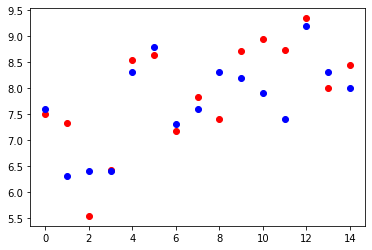

In [25]:
plt.scatter(df_regression.index[0:15], last_polluter.pollute(df_regression).Rate[0:15], color="red")
plt.scatter(df_regression.index[0:15], df_regression.Rate[0:15], color="blue")
#plt.gca().set_ylim([0,10])

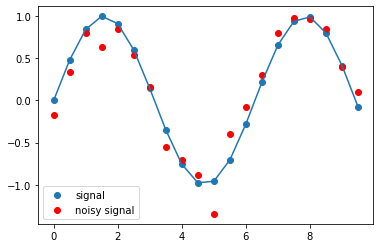

In [41]:
x = np.arange(0,10, 0.5)
plt.scatter(x,np.sin(x), label = "signal")
plt.plot(x,np.sin(x))
plt.scatter(x,np.sin(x) + np.random.normal(scale=0.2,size=len(x)), color="red", label="noisy signal")
plt.legend()
plt.savefig("/mnt/g/Studium/Master V/dataqualiy_4ai/figures/noise.png", dpi=150)

In [62]:
last_polluter.pollute(df_regression).Rate.mean(), df_regression.Rate.mean()

(6.912039058343426, 6.876672784915735)

In [ ]:
print(df_regression.shape)
df_regression.head()

In [ ]:
5993 * 0.2

In [ ]:
from sklearn.linear_model import LinearRegression
attributes = ["Votes","Genre","Duration","Type","Certificate","Episodes","Nudity","Violence","Profanity","Alcohol","Frightening"]

clf = LinearRegression().fit(pd.get_dummies(df_regression[attributes]).iloc[1198:], df_regression["Rate"].iloc[1198:])
clf.score(pd.get_dummies(df_regression[attributes]).iloc[0:1198], df_regression["Rate"].iloc[0:1198])

In [ ]:
for poll in ["original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]:
    clf = LinearRegression().fit(pd.get_dummies(df_reg[attributes]).iloc[1198:], df_reg[poll].iloc[1198:])
    print(f"Pollution: {poll}")
    orig_score = clf.score(pd.get_dummies(df_reg[attributes]).iloc[0:1198], df_reg["original"].iloc[0:1198])
    polluted_score = clf.score(pd.get_dummies(df_reg[attributes]).iloc[0:1198], df_reg[poll].iloc[0:1198])
    print(f"org score: {orig_score}, polluted_score: {polluted_score}")

In [ ]:
for poll in ["original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]:
    clf = LinearRegression().fit(pd.get_dummies(df_reg_experimental[attributes]).iloc[1198:], df_reg_experimental[poll].iloc[1198:])
    print(f"Pollution: {poll}")
    orig_score = clf.score(pd.get_dummies(df_reg_experimental[attributes]).iloc[0:1198], df_reg_experimental["original"].iloc[0:1198])
    polluted_score = clf.score(pd.get_dummies(df_reg_experimental[attributes]).iloc[0:1198], df_reg_experimental[poll].iloc[0:1198])
    print(f"org score: {orig_score}, polluted_score: {polluted_score}")

In [ ]:
df_reg = df_regression.copy()
df_reg = df_reg.rename({"Rate":"original"}, axis=1)

polluter_std_025 = TargetAccuracyPolluter(0.25,"original", False, pollution_method = "std", random_seed=1)
polluter_std_05 = TargetAccuracyPolluter(0.5,"original", False, pollution_method = "std", random_seed=1)
polluter_std_075 = TargetAccuracyPolluter(0.75,"original", False, pollution_method = "std", random_seed=1)
polluter_std_1 = TargetAccuracyPolluter(1.,"original", False, pollution_method = "std", random_seed=1)

df_reg["pollution 0.25"] = polluter_std_025.pollute(df_reg).original.values
df_reg["pollution 0.5"] = polluter_std_05.pollute(df_reg).original.values
df_reg["pollution 0.75"] = polluter_std_075.pollute(df_reg).original.values
df_reg["pollution 1.0"] = polluter_std_1.pollute(df_reg).original.values

In [ ]:
sns.displot(df_reg[["original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]], kind="kde", linewidth=3.5, alpha=0.6, bw_adjust=.25)
plt.grid()
# plt.vlines(df_reg.original.mean(), ymin=0.0, ymax=0.08, color="black", linewidth=3, label="Mean")
#plt.vlines(df_reg["pollution 0.25"].mean(), ymin=0.0, ymax=0.001, color="red")
# plt.title("pollution input = std of gaussian noise distribution")
# plt.legend(loc="upper right")
# plt.savefig("pollution_kde.png",dpi=300)
plt.show()

In [ ]:
df_reg[["Genre","original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]].sample(5)

In [ ]:
df_reg_experimental = df_reg.copy()

In [ ]:
for col in ["original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]:
    df_reg_experimental[col] = df_reg_experimental[col].apply(lambda x: 0.0 if x < 0.0 else x)
    df_reg_experimental[col] = df_reg_experimental[col].apply(lambda x: 10.0 if x > 10.0 else x)

In [ ]:
df_reg_experimental["pollution 0.25"].min()

In [ ]:
sns.displot(df_reg_experimental[["original", "pollution 0.25", "pollution 0.5", "pollution 0.75", "pollution 1.0"]], kind="kde", linewidth=3.5, alpha=0.6, bw_adjust=.25)
plt.grid()
# plt.vlines(df_reg.original.mean(), ymin=0.0, ymax=0.08, color="black", linewidth=3, label="Mean")
#plt.vlines(df_reg["pollution 0.25"].mean(), ymin=0.0, ymax=0.001, color="red")
# plt.title("pollution input = std of gaussian noise distribution")
# plt.legend(loc="upper right")
plt.savefig("/mnt/g/Studium/Master V/dataqualiy_4ai/figures/pollution_kde_cutoff.png",dpi=300)
plt.show()

In [ ]:
qualities_std = []
qualities_variance = []
qualities_mean = []
qualities_blubb = []
qualities_categorical = []
x = np.arange(start=0.0,stop=2., step=0.05)
for pollution_parameter in x:
    polluter_std = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="std", random_seed=477)
    # polluter_variance = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="variance", random_seed=477)
    # polluter_mean = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="mean", random_seed=477)
    # polluter_blubb = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="lambda scaling", random_seed=477)
    

    qualities_std.append(polluter_std.compute_quality_measure(df_regression, polluter_std.pollute(df_regression)))
    # qualities_variance.append(polluter_variance.compute_quality_measure(df_regression, polluter_variance.pollute(df_regression)))
    # qualities_mean.append(polluter_mean.compute_quality_measure(df_regression, polluter_mean.pollute(df_regression)))
    # qualities_blubb.append(polluter_blubb.compute_quality_measure(df_regression, polluter_blubb.pollute(df_regression)))
    if(pollution_parameter <= 1.0):
        polluter_categorical = TargetAccuracyPolluter(pollution_parameter, "kredit", True, random_seed=477)
        qualities_categorical.append(polluter_categorical.compute_quality_measure(df_classification, polluter_categorical.pollute(df_classification)))

plt.plot(x, qualities_std, label="numercial target")
# plt.plot(x, qualities_variance, label="λ = variance, mean = 0")
# plt.plot(x, qualities_mean, label="λ = mean, variance = 0.5")
# plt.plot(x, qualities_blubb, label="λ scaling, mean = 1, variance = 0.5")
plt.plot(np.arange(start=0.0,stop=1.01, step=0.05), qualities_categorical, label="categorical target")
plt.xlabel("pollution parameter λ")
plt.ylabel("target accuracy quality measure")
#plt.xticks(np.arange(start=0.0,stop=1.3, step=0.1))
plt.yticks(np.arange(start=0.0,stop=1.1, step=0.1))
plt.grid()
plt.title("Pollution Methods for Numerical and Categorical Targets")

ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.legend()
plt.savefig("/mnt/g/Studium/Master V/dataqualiy_4ai/figures/pollution_difference_cat_numerical.png", dpi=300)
plt.show()

In [ ]:
qualities_std = []
qualities_variance = []
qualities_mean = []
qualities_blubb = []
x = np.arange(start=0.0,stop=2., step=0.05)
for pollution_parameter in x:
    polluter_std = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="std", random_seed=477)
    polluter_variance = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="variance", random_seed=477)
    polluter_mean = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="mean", random_seed=477)
    # polluter_blubb = TargetAccuracyPolluter(pollution_parameter,"target", False, pollution_method="lambda scaling", random_seed=477)

    qualities_std.append(polluter_std.compute_quality_measure(df_regression, polluter_std.pollute(df_regression, use_qdiff=False)))
    qualities_variance.append(polluter_variance.compute_quality_measure(df_regression, polluter_variance.pollute(df_regression, use_qdiff=False)))
    qualities_mean.append(polluter_mean.compute_quality_measure(df_regression, polluter_mean.pollute(df_regression, use_qdiff=False)))
    # qualities_blubb.append(polluter_blubb.compute_quality_measure(df_regression, polluter_blubb.pollute(df_regression, use_qdiff=True)))

plt.plot(x, qualities_std, label="λ = std")
plt.plot(x, qualities_variance, label="λ = variance")
plt.plot(x, qualities_mean, label="λ = mean")
# plt.plot(x, qualities_blubb, label="λ scaling, mean = 1, variance = 0.5")
plt.xlabel("pollution parameter")
plt.ylabel("target accuracy quality measure")
#plt.xticks(np.arange(start=0.0,stop=1.3, step=0.1))
plt.yticks(np.arange(start=0.0,stop=1.1, step=0.1))
plt.grid()
plt.title("Pollution Methods for Numerical Targets, scaled by mean")

ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.legend()
plt.savefig("/mnt/g/Studium/Master V/dataqualiy_4ai/figures/std_pollution.png", dpi=300)
plt.show()

In [ ]:
df_reg = df_regression.copy()
df_reg = df_reg.rename({"target":"original"}, axis=1)

polluter_std_025 = TargetAccuracyPolluter(0.25,"original", False, pollution_method = "std", random_seed=1)
polluter_std_05 = TargetAccuracyPolluter(0.5,"original", False, pollution_method = "std", random_seed=1)
polluter_std_075 = TargetAccuracyPolluter(0.75,"original", False, pollution_method = "std", random_seed=1)
polluter_std_1 = TargetAccuracyPolluter(1.,"original", False, pollution_method = "std", random_seed=1)

df_reg["pollution 0.25"] = polluter_std_025.pollute(df_reg).original.values
df_reg["pollution 0.5"] = polluter_std_05.pollute(df_reg).original.values
df_reg["pollution 0.75"] = polluter_std_075.pollute(df_reg).original.values
df_reg["pollution 1.0"] = polluter_std_1.pollute(df_reg).original.values

In [ ]:
df_reg.original.mode()

In [ ]:
sns.displot(df_reg, kind="kde", linewidth=3.5, alpha=0.6)
plt.grid()
plt.vlines(df_reg.original.mean(), ymin=0.0, ymax=0.001, color="black", linewidth=3, label="Mean")
#plt.vlines(df_reg["pollution 0.25"].mean(), ymin=0.0, ymax=0.001, color="red")
plt.title("pollution input = std of gaussian noise distribution")
plt.legend(loc="upper right")
plt.savefig("pollution_kde.png",dpi=300)
plt.show()

In [ ]:
np.mean(np.abs(np.random.normal(0,1,10000)))

In [ ]:
plt.hist(np.abs(np.random.normal(0,1,100000)), bins=40)

In [ ]:



sns.histplot()
#sns.histplot(polluter_std_05.pollute(df_regression), color="red", label="pollution=0.5")
#sns.histplot(polluter_std_075.pollute(df_regression), color="blue", label="pollution=0.75")
plt.legend()
plt.title("Std Pollution on the Data")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

In [ ]:
df_regression

In [ ]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Clustering

In [ ]:
clustering_df = pd.read_csv("/mnt/g/Studium/Master V/dataqualiy_4ai/datasets/clustering/bank.csv", sep=",")
#df_classification = pd.read_csv("/mnt/g/Studium/Master V/dataqualiy_4ai/datasets/SouthGermanCredit.csv", sep=",")

In [ ]:
clustering_df.education.unique()

In [ ]:
cluster_polluter = TargetAccuracyPolluter(0.5,"education", True, random_seed=1)

In [ ]:
polluted_clustering_df = cluster_polluter.pollute(clustering_df)

In [ ]:
polluted_clustering_df.education.value_counts()

In [ ]:
index = np.arange(len(clustering_df.education.unique()))
bar_width = 0.35

fig, ax = plt.subplots()
clean = ax.bar(index, clustering_df["education"].value_counts(), bar_width,
                label="clean data")

polluted = ax.bar(index+bar_width, polluted_clustering_df["education"].value_counts(),
                 bar_width, label="pollluted")

ax.set_xlabel('Category')
ax.set_ylabel('Incidence')
ax.set_title('Crime incidence by season, type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["ASB", "Violence", "Theft", "Public Order", "Drugs"])
ax.legend()

plt.show()

In [ ]:
diff_df = (clustering_df.education.value_counts() - polluted_clustering_df.education.value_counts())

In [ ]:
fig, ax = plt.subplots()
ax.bar(diff_df.index, diff_df.values)

In [ ]:
ax = plt.subplot(111)

ax.bar(clustering_df.education.value_counts().keys(), clustering_df.education.value_counts().values)
ax.bar(polluted_clustering_df.education.value_counts().keys(), polluted_clustering_df.education.value_counts().values, color="red")
# polluted_clustering_df.education.hist()
# clustering_df.education.hist()
plt.xticks(rotation=90)

In [ ]:
random_targets = pd.DataFrame({"target":np.random.choice([1,2,3], size=1000)})

for poll in np.arange(start=0.0, stop=1.0, step=0.1):
    polluter = TargetAccuracyPolluter(poll,"target", True, random_seed=1)
    random_targets_polluted = polluter.pollute(random_targets)
    score = fowlkes_mallows_score(random_targets.target.values,random_targets_polluted.target.values)
    print(f"pollution: {np.round(poll, decimals=1)}, score: {score}")

In [ ]:
fowlkes_mallows_score([0, 0, 1, 1], [0, 0, 0, 0])